In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from sklearn.decomposition import PCA
from sklearn import preprocessing
import os
import pickle as pickle
import numpy as np
import pandas as pd
import pickle as pickle
import time as time
import matplotlib.pyplot as plt
import glob as glob
import multiprocessing as mpro
from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colors_bupu = ['#f7fcfd', '#e0ecf4', '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#810f7c', '#4d004b']

/home/pukkasahib/.venvs/mdanalysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Our goal is to perform a PCA of the crystal structures of A2A
- We want to reveal the differences between the active and inactive crystal structures.
- We can then see how our simulations explore this 'crystal PCA space' to determine which structures the simulations are more similar to.

In [2]:
with open('./data/a2a_dictionary.pkl', 'rb') as ff:
    a2a_dictionary = pickle.load(ff)

### We must first compute the feature vector that contains the pairwise distances between all alpha-carbons of our structures.

In [3]:
crystal_pwdists_holder = []

# loop over each universe (each crystal structure that has the MSA aligned selection of topologically equivalent residues)
for pdbID in a2a_dictionary.keys():
    # set the universe
    uni     = a2a_dictionary[pdbID]
    # compute the pairwise distances between all residues (upper-triangular part of a matrix that has residues on the x and y axis)
    pwdists = distances.self_distance_array(uni.select_atoms('name CA').positions)
    # append each pairwise distance to the list
    crystal_pwdists_holder.append(pwdists)

# verify the length of each set of pairwise distances (should all be the same N*(N-1) / 2, N = n_residues!!)
print(list(crystal_pwdists_holder[i].shape for i in range(14))
     )

[(34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,), (34453,)]


### We can now perform the principal component analysis.
- We make use of the sci-kit learn library in python that already has the functions to perform the PCA. Let's walk through the steps that we need to perform that are very similar to the previous, simple, example that we performed.

In [4]:
%%time

# make into a dataframe and then get the value sof the data frame.
# each column is a residue position, each row is a unique structure 
crystal_df = pd.DataFrame(crystal_pwdists_holder)
pwdists    = crystal_df.values

# scale the data to have mean = 0 and std = 1
scaler               = preprocessing.StandardScaler()
pwdists_standardized = scaler.fit_transform(pwdists)

# confirm this by computing the average and std of each col!

## next we create the PCA object that will perform the transformation of our data

# set number of PCs to keep
nPcs               = 10
crystalPCA         = PCA(n_components=nPcs)
crystalProjections = crystalPCA.fit_transform(pwdists_standardized)
explained_per_var  = np.round(crystalPCA.explained_variance_ratio_*100,) # how much variance is explained by each PC

CPU times: user 2.3 s, sys: 83.7 ms, total: 2.38 s
Wall time: 546 ms


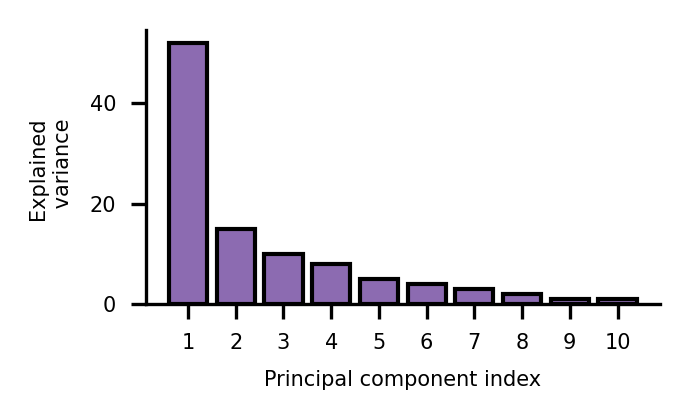

In [5]:
plt.figure(dpi=300, figsize=(2.4, 1.5))

plt.bar(x=range(10), height=explained_per_var, color=colors_bupu[-4], edgecolor='k', lw=1)
plt.xticks(range(0, 10, 1), range(1, 11, 1), fontsize=5)
plt.yticks(fontsize=5)

plt.xlabel('Principal component index', fontsize=5)
plt.ylabel('Explained \n variance', fontsize=5)

plt.tight_layout()
plt.show()

### Let us now plot the crystal structures on our new space defined by the top two principal components.

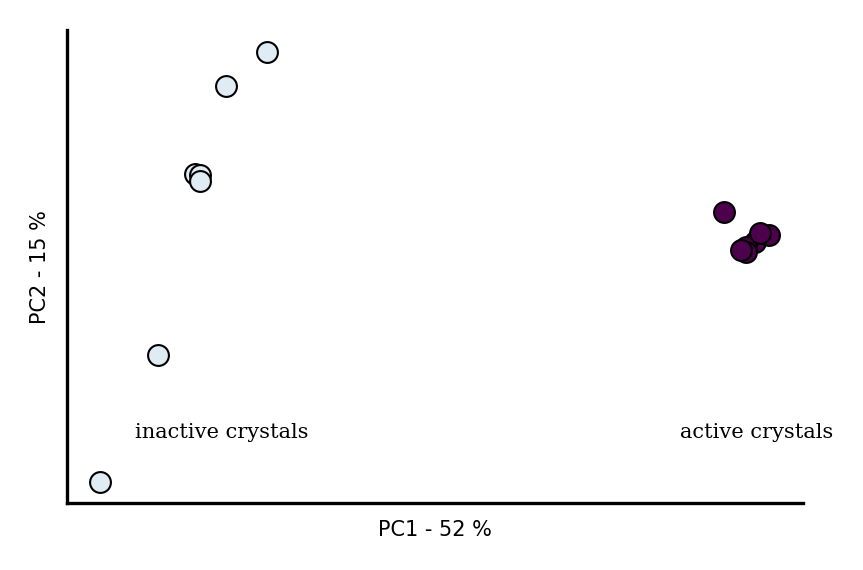

In [6]:
import matplotlib.patheffects as PathEffects

plt.figure(dpi=300, figsize=(3,2))


# to color the structures we will separate by x-axis positions, since it is easiest...
for i,coordinate in enumerate(zip(crystalProjections.T[0], crystalProjections.T[1])): # x and y coords of new PCs
    if coordinate[0] < 0:
        plt.scatter(x = coordinate[0], y=coordinate[1],  color = colors_bupu[1], edgecolor='k', lw=0.5, s=100, marker = '.')
    elif coordinate[0] > 0:
        plt.scatter(x = coordinate[0], y=coordinate[1], color = colors_bupu[-1], edgecolor='k', lw=0.5, s=100, marker = '.')

txt1 = plt.text(100, -150, s='active crystals', fontsize=5, family='serif', color='k')
txt2 = plt.text(-160, -150, s='inactive crystals', fontsize=5, family='serif', color='k')

plt.xticks([], fontsize=5)
plt.yticks([], fontsize=5)

plt.xlabel(f'PC1 - {int(explained_per_var[0])} %', fontsize=5)
plt.ylabel(f'PC2 - {int(explained_per_var[1])} %', fontsize=5)

plt.tight_layout()
plt.show()

### How can we interpret PC1? What does it physically correspond to regarding the protein structure?
- Remember that the PCs are a linear combination of the original data -- the original data were pairwise distances.
- PC1 is a linear combinaton of the pairwise distances. We can see which pairwise distances contribute the most to PC1 by looking at a heat map.

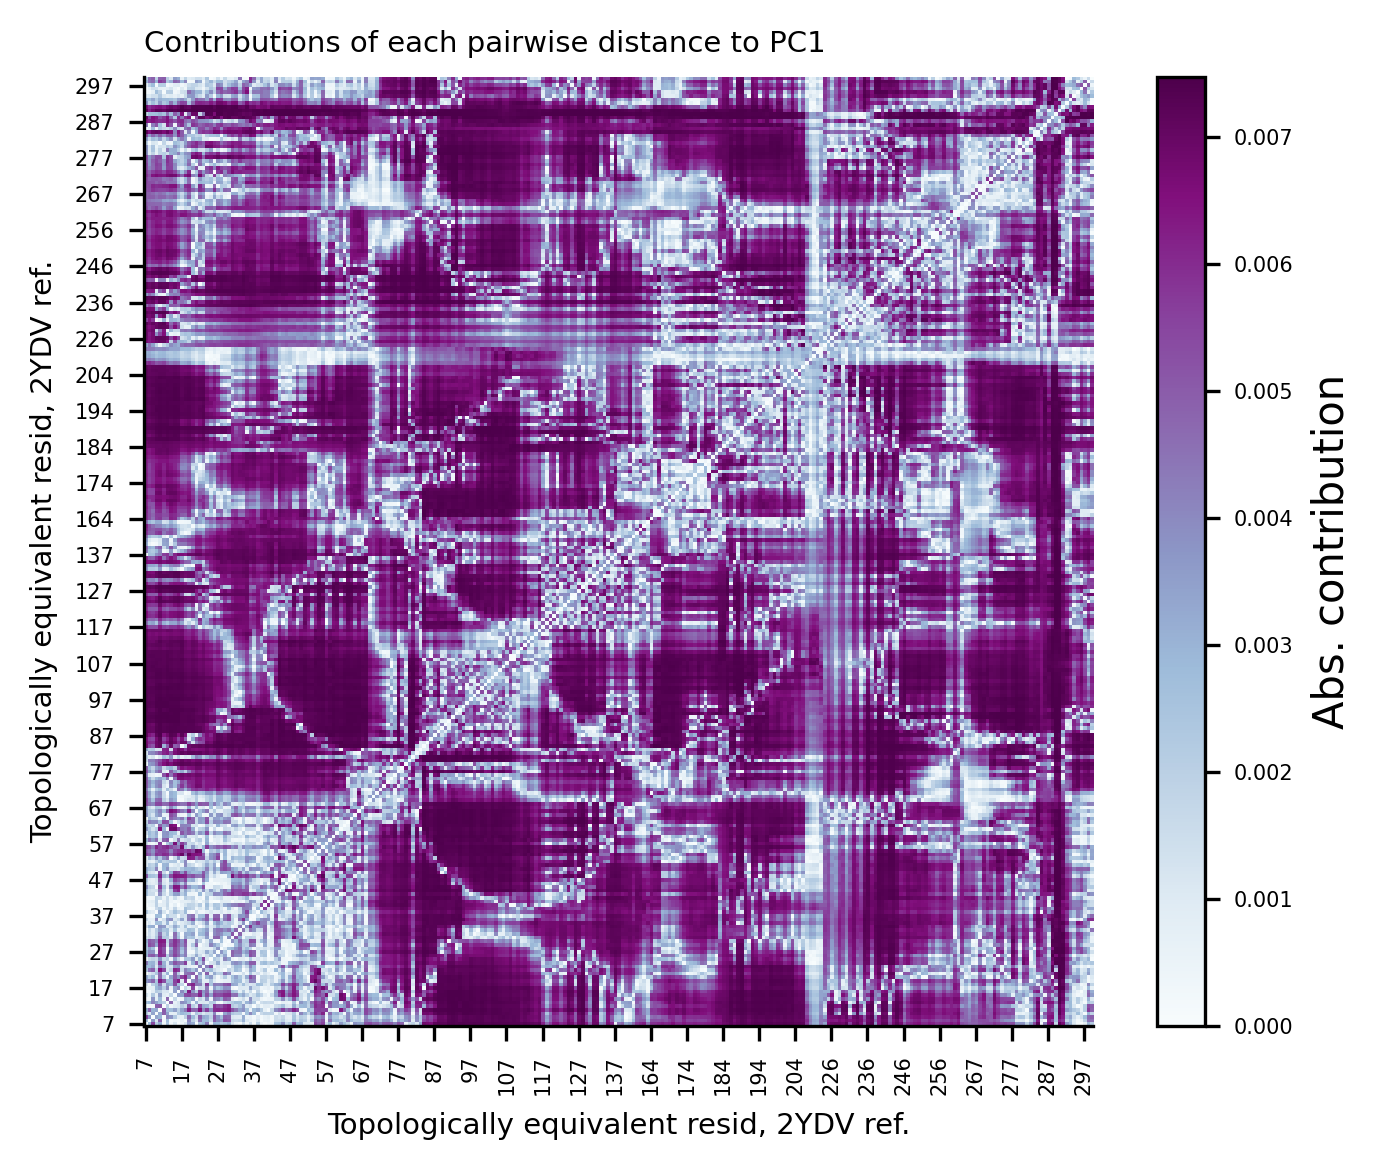

In [7]:
contributions = pd.DataFrame(crystalPCA.components_.T, columns = np.array(list(f'PC {i}' for i in range(1, 11, 1))))
# print(contributions)

# let's focus on PC1
pc1_values         = contributions.values.T[0]
n_residues         = a2a_dictionary['2ydo'].residues.n_residues
pc1_heatmap        = np.zeros((n_residues, n_residues))
triu               = np.triu_indices(n_residues, 1) ## ofset by 1 to get upper-triangular portion
pc1_heatmap [triu] = pc1_values

plt.figure(dpi=300, figsize=(5,4))
plt.imshow(np.abs(pc1_heatmap + pc1_heatmap.T), origin='lower', cmap='BuPu')

residues = a2a_dictionary['2ydv'].residues.resids
plt.xticks(range(len(residues))[::10], residues[::10], fontsize=5, rotation=90)
plt.yticks(range(len(residues))[::10], residues[::10], fontsize=5)
plt.xlabel('Topologically equivalent resid, 2YDV ref.', fontsize=7)
plt.ylabel('Topologically equivalent resid, 2YDV ref.', fontsize=7)
plt.title('Contributions of each pairwise distance to PC1', fontsize=7, loc='left')
cbar = plt.colorbar(label = 'Abs. contribution')
cbar.ax.tick_params(labelsize=5) 

plt.tight_layout()
plt.show()

### How do my trajectories 'sample this PCA space'?

In [8]:
%%time

from tqdm import tqdm

stride=1

selectionStrings = np.load('./data/msa_selectionStringHolder.npy', allow_pickle=True)
uni              = mda.Universe('./data/a2a_trajs/traj0.gro',
                                ['./data/a2a_trajs/traj0.xtc', './data/a2a_trajs/traj1.xtc'])
traj_pwdists = []

for ts in tqdm(uni.trajectory[::stride]):
    pwdist = distances.self_distance_array(uni.select_atoms('protein and name CA and (' + selectionStrings[0][:-4] + ')').positions)
    traj_pwdists.append(pwdist)

trajScaled      = scaler.transform(traj_pwdists) # transform - don't fit! already fitted on crystal data
trajProjections = crystalPCA.transform(trajScaled)

100%|███████████████████████████████████████████████████| 405/405 [00:58<00:00,  6.94it/s]


CPU times: user 57.3 s, sys: 784 ms, total: 58.1 s
Wall time: 59 s


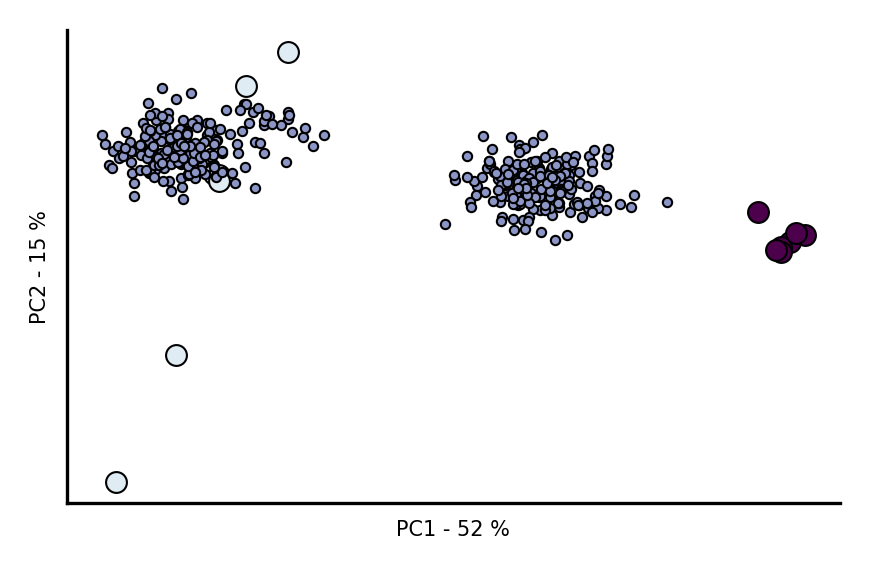

In [9]:
traj_x, traj_y = trajProjections.T[0], trajProjections.T[1]

plt.figure(dpi=300, figsize=(3,2))

# to color the structures we will separate by x-axis positions, since it is easiest...
for i,coordinate in enumerate(zip(crystalProjections.T[0], crystalProjections.T[1])): # x and y coords of new PCs
    if coordinate[0] < 0:
        plt.scatter(x = coordinate[0], y=coordinate[1],  color = colors_bupu[1], edgecolor='k', lw=0.5, s=100, marker = '.')
    elif coordinate[0] > 0:
        plt.scatter(x = coordinate[0], y=coordinate[1], color = colors_bupu[-1], edgecolor='k', lw=0.5, s=100, marker = '.')

## plot the trajectories on this space

plt.scatter(x = traj_x, y = traj_y, s = 20, color = colors_bupu[4], marker='.', edgecolor='k', lw = 0.5)

plt.xticks([], fontsize=5)
plt.yticks([], fontsize=5)

plt.xlabel(f'PC1 - {int(explained_per_var[0])} %', fontsize=5)
plt.ylabel(f'PC2 - {int(explained_per_var[1])} %', fontsize=5)

plt.tight_layout()
plt.show()